# Part 2- Building the ML Dataset

Created by Michael Casey, Andrew Cruez, Peter Stewart, and Hemraj Yadav

__About Part 2__

This section of the prject is focused on feature engineering. In this part, each group member worked on different types of feature engineering in order to take our raw data and organize it in the best possible way to make it useful for machine learning. The end result will combine the most usesful features into a master dataset that we will then use in the next part for our machine learning pipeline.

In [38]:
# Importing our modules and settings and loading our data from part 1

import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import featuretools as ft
import warnings
import pickle
import woodwork as ww
warnings.filterwarnings('ignore')

# Load data from part I
DATA_DIR = "./Data/home-credit-default-risk"

with open(f"{DATA_DIR}/datasets.pkl", 'rb') as n:
    datasets = pickle.load(n)

## **Data Lineage**

The sections below are the code and descriptions that cover the lineage of our data from the basic Kaggle CSV files to our final train and test datasets. Below is a diagram giving an overview of our process from start to finish.

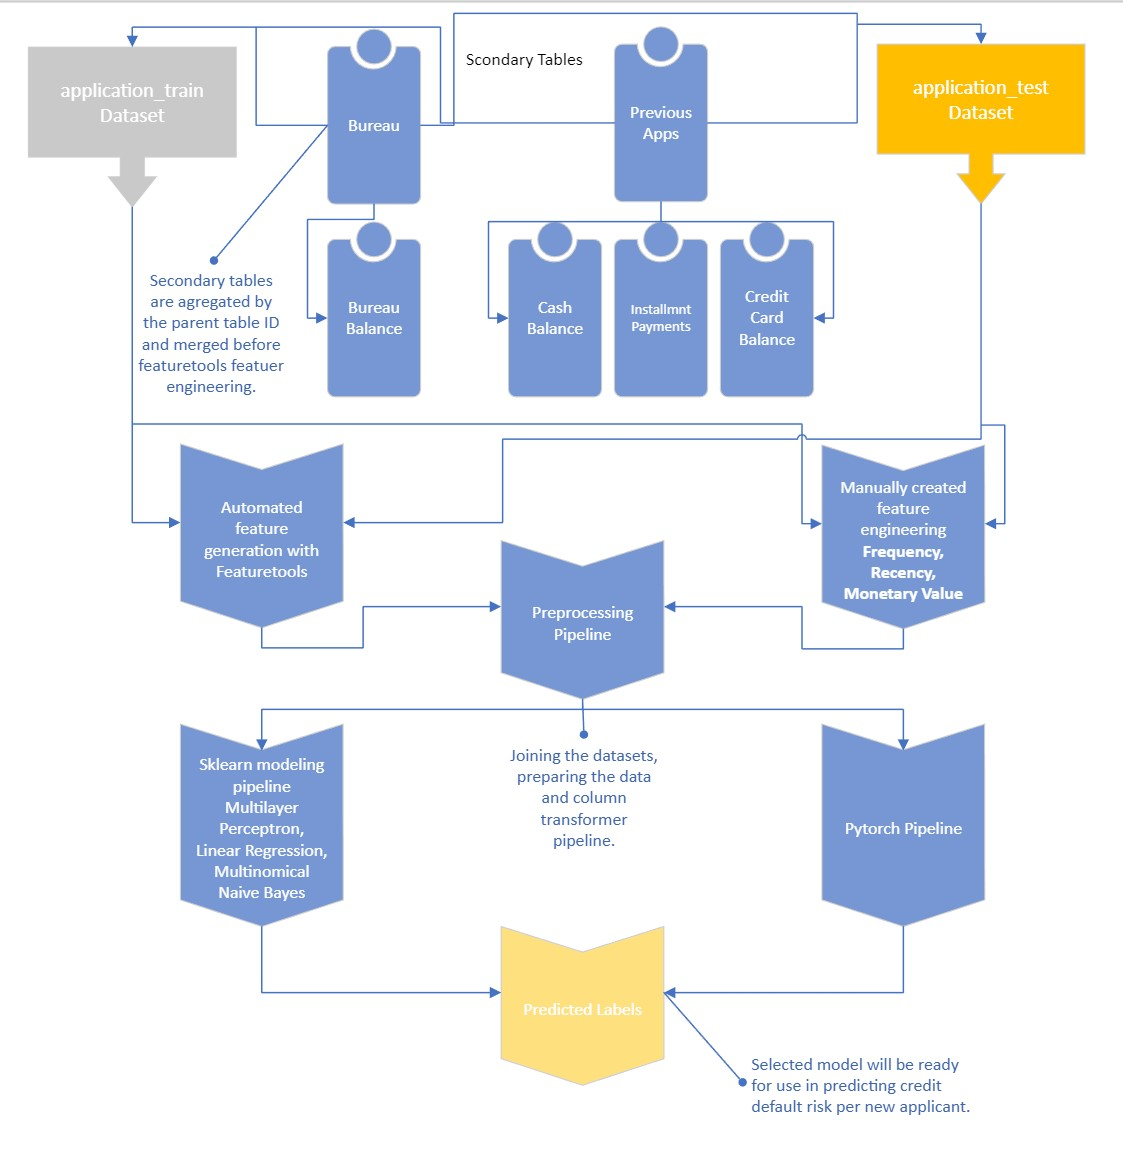

# Feature engineering- **Automated** (Featuretools)

## Data Description

Feature Engineering Automated- Featuretools is an automated tool for generating new features from an existing dataset. First, we will setup our datasets and define the dataframe dictionary and relationships list to help the program understand which datasets we want to create features for and how the datasets are connected to each other. Then we run a deep feature synthesis on the data during which featuretools will cycle through its primitives (different transformations on the data) and it will produce a feature matrix with new useful features based on the algorithm explained here (https://www.jmaxkanter.com/papers/DSAA_DSM_2015.pdf). Our implementation below was somewhat limited by the resource intensive nature of the deep feature synthesis process. It took several attempts to successfully generate features with the tool, the steps that we took to ensure results could be produced withing a few hours processing time were to reduce the number of features generated with the max_feature parameter. Max depth is the number of features that will be stacked together during the feature synthesis process and the default of 2 is what we used to also reduce the complexity and processing time. Another issue with this tool is the potential for data leakage. Based on some tutorials available on the web it seems to be common practice to combine the train and test datasets before doing deep feature synthesis to ensure the column transformations are the same for both train and test. We feel that this process could result in data leakage as the featuretools program may be using both train and test data to make determinations about which features to keep during deep feature synthesis. So, in order to prevent any leakage, we are taking the more challenging approach of separately running the feature transformations on the test set using a feature encoding from the train data which tells feature tools to create a matching set of features for test. After this was done we then took the further step of checking the columns in both data sets and only keeping matching column names for the final data.

In [2]:
#Lets set up the dataframes for feature engineering
#we'll remove target from the train dataset in order to prevent leakage. We will add back after automated engineering.

app_train_FT = datasets['application_train']
app_train_targets = app_train_FT[['TARGET', 'SK_ID_CURR']]
app_train_FT = app_train_FT.drop(['TARGET'], axis=1)

print(app_train_FT.shape)

app_test_FT = datasets['application_test']
print(app_test_FT.shape)

bureau_FT = datasets['bureau']

previous_FT = datasets['previous_application']

bureau_balance_FT = datasets['bureau_balance']

cash_FT = datasets['POS_CASH_balance']

installments_FT = datasets['installments_payments']


credit_FT = datasets['credit_card_balance']


(307511, 121)
(48744, 121)


## Set up secondary tables by aggregating by average based on that table's unique ID numbers.

In [3]:
#Processing selected data from bureau

print(bureau_FT.shape)
bft_skidb = bureau_FT[['SK_ID_CURR','SK_ID_BUREAU']]
bureau_FT.drop('SK_ID_BUREAU', axis=1, inplace=True)
bureau_FT = bureau_FT.groupby('SK_ID_CURR', as_index=False ).mean()
bureau_FT = bureau_FT.merge(bft_skidb, how='left', on='SK_ID_CURR')
print(bureau_FT.shape)
bureau_FT.head()
bureau_FT.head()


(1716428, 17)
(1716428, 14)


,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_BUREAU
0,100001,-735.0,0.0,82.428571,-825.5,NaN,0.0,207623.571429,85240.928571,0.0,0.0,-93.142857,3545.357143,5896630
1,100001,-735.0,0.0,82.428571,-825.5,NaN,0.0,207623.571429,85240.928571,0.0,0.0,-93.142857,3545.357143,5896631
2,100001,-735.0,0.0,82.428571,-825.5,NaN,0.0,207623.571429,85240.928571,0.0,0.0,-93.142857,3545.357143,5896632
3,100001,-735.0,0.0,82.428571,-825.5,NaN,0.0,207623.571429,85240.928571,0.0,0.0,-93.142857,3545.357143,5896633
4,100001,-735.0,0.0,82.428571,-825.5,NaN,0.0,207623.571429,85240.928571,0.0,0.0,-93.142857,3545.357143,5896634


In [4]:
#Processing selected data from bureau balance for featuretools

print(bureau_balance_FT.shape)
bureau_balance_FT = bureau_balance_FT.groupby('SK_ID_BUREAU', as_index=False ).mean()
print(bureau_balance_FT.shape)
bureau_balance_FT.head()


(27299925, 3)
(817395, 2)


,SK_ID_BUREAU,MONTHS_BALANCE
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [5]:
#Processing selected data from credit_card_balance data for X_kaggle_test
print(credit_FT.shape)
cred_sk = credit_FT[['SK_ID_PREV','SK_ID_CURR']]
credit_FT.drop('SK_ID_CURR', axis=1, inplace=True)
credit_FT = credit_FT.groupby('SK_ID_PREV', as_index=False ).mean()
credit_FT = credit_FT.merge(cred_sk, how='left', on='SK_ID_PREV')
print(credit_FT.shape)
credit_FT.head()

(3840312, 23)
(3840312, 22)


,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,1000018,-4.0,74946.285,81000.0,5400.0,29478.996,0.0,24078.996,2594.088,5541.75,...,73602.585,73602.585,1.2,8.8,0.0,7.6,2.0,0.0,0.0,394447
1,1000018,-4.0,74946.285,81000.0,5400.0,29478.996,0.0,24078.996,2594.088,5541.75,...,73602.585,73602.585,1.2,8.8,0.0,7.6,2.0,0.0,0.0,394447
2,1000018,-4.0,74946.285,81000.0,5400.0,29478.996,0.0,24078.996,2594.088,5541.75,...,73602.585,73602.585,1.2,8.8,0.0,7.6,2.0,0.0,0.0,394447
3,1000018,-4.0,74946.285,81000.0,5400.0,29478.996,0.0,24078.996,2594.088,5541.75,...,73602.585,73602.585,1.2,8.8,0.0,7.6,2.0,0.0,0.0,394447
4,1000018,-4.0,74946.285,81000.0,5400.0,29478.996,0.0,24078.996,2594.088,5541.75,...,73602.585,73602.585,1.2,8.8,0.0,7.6,2.0,0.0,0.0,394447


In [6]:
#Processing selected data from installments_payments data for train

print(installments_FT.shape)
inst_sk = installments_FT[['SK_ID_PREV','SK_ID_CURR']]
installments_FT.drop('SK_ID_CURR', axis=1, inplace=True)
installments_FT= installments_FT.groupby('SK_ID_PREV', as_index=False ).mean()
installments_FT = installments_FT.merge(inst_sk, how='left', on='SK_ID_PREV')
print(installments_FT.shape)
installments_FT.head()

(13605401, 8)
(13605401, 8)


,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1000001,1.50,1.5,-253.0,-269.00,34221.71250,34221.71250,158271
1,1000001,1.50,1.5,-253.0,-269.00,34221.71250,34221.71250,158271
2,1000002,1.25,2.5,-1555.0,-1574.75,9308.89125,9308.89125,101962
3,1000002,1.25,2.5,-1555.0,-1574.75,9308.89125,9308.89125,101962
4,1000002,1.25,2.5,-1555.0,-1574.75,9308.89125,9308.89125,101962


In [7]:
#Processing selected data from installments_payments data for X_kaggle_test

print(previous_FT.shape)
prev_sk = previous_FT[['SK_ID_PREV','SK_ID_CURR']]
previous_FT.drop('SK_ID_PREV', axis=1, inplace=True)
previous_FT= previous_FT.groupby('SK_ID_CURR', as_index=False ).mean()
previous_FT = previous_FT.merge(prev_sk, how='left', on='SK_ID_CURR')
print(previous_FT.shape)
previous_FT.head()

(1670214, 37)
(1670214, 21)


,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,SK_ID_PREV
0,100001,3951.000,24835.5,23787.0,2520.0,24835.5,13.000000,1.0,0.104326,NaN,...,-1740.0,23.0,8.0,365243.0,-1709.000000,-1499.000000,-1619.000000,-1612.000000,0.000000,1369693
1,100002,9251.775,179055.0,179055.0,0.0,179055.0,9.000000,1.0,0.000000,NaN,...,-606.0,500.0,24.0,365243.0,-565.000000,125.000000,-25.000000,-17.000000,0.000000,1038818
2,100003,56553.990,435436.5,484191.0,3442.5,435436.5,14.666667,1.0,0.050030,NaN,...,-1305.0,533.0,10.0,365243.0,-1274.333333,-1004.333333,-1054.333333,-1047.333333,0.666667,1810518
3,100003,56553.990,435436.5,484191.0,3442.5,435436.5,14.666667,1.0,0.050030,NaN,...,-1305.0,533.0,10.0,365243.0,-1274.333333,-1004.333333,-1054.333333,-1047.333333,0.666667,2636178
4,100003,56553.990,435436.5,484191.0,3442.5,435436.5,14.666667,1.0,0.050030,NaN,...,-1305.0,533.0,10.0,365243.0,-1274.333333,-1004.333333,-1054.333333,-1047.333333,0.666667,2396755


In [8]:

print(cash_FT.shape)
cash_sk = cash_FT[['SK_ID_PREV','SK_ID_CURR']]
cash_FT.drop('SK_ID_CURR', axis=1, inplace=True)
cash_FT = cash_FT.groupby('SK_ID_PREV', as_index=False ).mean()
cash_FT = cash_FT.merge(cash_sk, how='left', on='SK_ID_PREV')
print(cash_FT.shape)
cash_FT.head()

(10001358, 8)
(10001358, 7)


,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,1000001,-9.0,8.666667,7.666667,0.0,0.0,158271
1,1000001,-9.0,8.666667,7.666667,0.0,0.0,158271
2,1000001,-9.0,8.666667,7.666667,0.0,0.0,158271
3,1000002,-52.0,5.200000,2.000000,0.0,0.0,101962
4,1000002,-52.0,5.200000,2.000000,0.0,0.0,101962


In [9]:
#modified from https://github.com/Featuretools/
# Ensuring that indexes are set for each table
for index in ['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']:
    for dataset in [app_train_FT, app_test_FT, bureau_FT, bureau_balance_FT, previous_FT, cash_FT , installments_FT, credit_FT]:
        if index in list(dataset.columns):
            dataset[index] = dataset[index].fillna(0).astype(np.int64)
            


## Deep Feature Synthesis

In [10]:
#modified from https://featuretools.alteryx.com/en/stable/generated/featuretools.dfs.html

dataframes_1 = {
    "app_train_FT": (app_train_FT, "SK_ID_CURR"),
    "previous_FT": (previous_FT, "SK_ID_PREV" ),
    "cash_FT": (cash_FT, "cash_FT_index"),
    "installments_FT": (installments_FT, "installments_FT_index"),
    "credit_FT": (credit_FT, "credit_FT_index"),
    "bureau_FT": (bureau_FT, "SK_ID_BUREAU"),
    "bureau_balance_FT": (bureau_balance_FT, "bureaubalance_FT_index"),
}

relationships_1 = [
    ("app_train_FT", "SK_ID_CURR", "previous_FT", "SK_ID_CURR"),
    ("previous_FT", "SK_ID_PREV", "cash_FT", "SK_ID_PREV"),
    ("previous_FT", "SK_ID_PREV", "installments_FT", "SK_ID_PREV"),
    ("previous_FT", "SK_ID_PREV", "credit_FT", "SK_ID_PREV"),
    ("app_train_FT", "SK_ID_CURR", "bureau_FT", "SK_ID_CURR"),
    ("bureau_FT", "SK_ID_BUREAU", "bureau_balance_FT", "SK_ID_BUREAU"),
]

# es = ft.EntitySet(id="train_data")
# es = es.add_dataframe(
#     dataframe_name="transactions",
#     dataframe=transactions_df,
#     index="transaction_id",
#     time_index="transaction_time",
#     logical_types={
#         "product_id": Categorical,
#         "zip_code": PostalCode,
#     },
# )

ignore_col = {"app_train_FT": ["SK_ID_CURR"], "previous_FT":["SK_ID_PREV"], "previous_FT":["SK_ID_CURR"], "cash_FT":["SK_ID_PREV"], "cash_FT": ["SK_ID_CURR"], "credit_FT": ["SK_ID_PREV"], 
              "credit_FT": ["SK_ID_CURR"], "installments_FT":["SK_ID_PREV"], "installments_FT": ["SK_ID_CURR"],"bureau_FT": ["SK_ID_CURR"], "bureau_FT": ["SK_ID_BUREAU"], "bureau_balance_FT": ["SK_ID_BUREAU"]
}

feature_matrix_train, features_defs = ft.dfs(
    dataframes=dataframes_1,
    relationships=relationships_1,
    target_dataframe_name="app_train_FT",
    agg_primitives=["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"],
    trans_primitives=None,
    ignore_columns=ignore_col,
    max_features=1200
)

feature_matrix_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,STD(previous_FT.MAX(credit_FT.CNT_INSTALMENT_MATURE_CUM)),STD(previous_FT.MAX(credit_FT.MONTHS_BALANCE)),STD(previous_FT.MAX(credit_FT.SK_DPD)),STD(previous_FT.MAX(credit_FT.SK_DPD_DEF)),STD(previous_FT.MAX(installments_FT.AMT_INSTALMENT)),STD(previous_FT.MAX(installments_FT.AMT_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_ENTRY_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_INSTALMENT)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_NUMBER)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_VERSION))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,Cash loans,M,False,True,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,Cash loans,F,False,False,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,NaN,NaN,NaN,NaN,79779.051329,79779.051329,850.230624,850.637604,1.607275,0.082479
100004,Revolving loans,M,True,True,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,Cash loans,F,False,True,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,389760.090982,389760.090982,214.605460,194.294450,2.254625,0.529150
100007,Cash loans,M,False,True,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,8999.969589,8634.953456,792.114868,795.134247,1.346359,0.289374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,Cash loans,M,False,False,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456252,Cash loans,F,False,True,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456253,Cash loans,F,False,True,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,1128.618790,1690.499274,680.425285,688.014898,0.636396,0.000000


In [17]:
feature_mat_num_cols = feature_matrix_train.select_dtypes(include=['number']).columns
feature_matrix_train[feature_mat_num_cols] = feature_matrix_train[feature_mat_num_cols].fillna(0, inplace=False)
feature_matrix_train.head()


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,STD(previous_FT.MAX(credit_FT.CNT_INSTALMENT_MATURE_CUM)),STD(previous_FT.MAX(credit_FT.MONTHS_BALANCE)),STD(previous_FT.MAX(credit_FT.SK_DPD)),STD(previous_FT.MAX(credit_FT.SK_DPD_DEF)),STD(previous_FT.MAX(installments_FT.AMT_INSTALMENT)),STD(previous_FT.MAX(installments_FT.AMT_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_ENTRY_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_INSTALMENT)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_NUMBER)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_VERSION))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,Cash loans,M,False,True,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100003,Cash loans,F,False,False,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.0,0.0,0.0,0.0,79779.051329,79779.051329,850.230624,850.637604,1.607275,0.082479
100004,Revolving loans,M,True,True,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100006,Cash loans,F,False,True,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,389760.090982,389760.090982,214.605460,194.294450,2.254625,0.529150
100007,Cash loans,M,False,True,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,8999.969589,8634.953456,792.114868,795.134247,1.346359,0.289374


In [18]:
#Replicate above process for test

feature_matrix_train.ww.init()

feature_matrix_enc_1, features_enc_1 = ft.encode_features(feature_matrix=feature_matrix_train, features=features_defs)

feature_matrix_enc_1

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE = terraced house,HOUSETYPE_MODE is unknown,WALLSMATERIAL_MODE = Panel,"WALLSMATERIAL_MODE = Stone, brick",WALLSMATERIAL_MODE = Block,WALLSMATERIAL_MODE = Wooden,WALLSMATERIAL_MODE = Mixed,WALLSMATERIAL_MODE = Monolithic,WALLSMATERIAL_MODE = Others,WALLSMATERIAL_MODE is unknown
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,False,True,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,False,False,False,True,False,False,False,False,False,False
100003,False,False,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,False,False,False,False,True,False,False,False,False,False
100004,True,True,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,False,True,False,False,False,False,False,False,False,True
100006,False,True,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,False,False,False,False,False,False,True
100007,False,True,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,False,False,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,False,False,False,True,False,False,False,False,False,False
456252,False,True,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,False,False,False,True,False,False,False,False,False,False
456253,False,True,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,False,False,True,False,False,False,False,False,False,False


## Set up test set for dfs replication for the test data

In [19]:
del app_train_FT
del dataframes_1
del relationships_1

app_train_FT = datasets['application_test']

dataframes_1 = {
    "app_train_FT": (app_train_FT, "SK_ID_CURR"),
    "previous_FT": (previous_FT, "SK_ID_PREV" ),
    "cash_FT": (cash_FT, "cash_FT_index"),
    "installments_FT": (installments_FT, "installments_FT_index"),
    "credit_FT": (credit_FT, "credit_FT_index"),
    "bureau_FT": (bureau_FT, "SK_ID_BUREAU"),
    "bureau_balance_FT": (bureau_balance_FT, "bureaubalance_FT_index"),
}

relationships_1 = [
    ("app_train_FT", "SK_ID_CURR", "previous_FT", "SK_ID_CURR"),
    ("previous_FT", "SK_ID_PREV", "cash_FT", "SK_ID_PREV"),
    ("previous_FT", "SK_ID_PREV", "installments_FT", "SK_ID_PREV"),
    ("previous_FT", "SK_ID_PREV", "credit_FT", "SK_ID_PREV"),
    ("app_train_FT", "SK_ID_CURR", "bureau_FT", "SK_ID_CURR"),
    ("bureau_FT", "SK_ID_BUREAU", "bureau_balance_FT", "SK_ID_BUREAU"),
]


## Create Feature Encoding to Replicate feature generation on test dataset

In [20]:
feature_matrix_test_1 = ft.calculate_feature_matrix(features=features_enc_1, dataframes = dataframes_1, relationships = relationships_1)
feature_matrix_test_1.head()

,NAME_CONTRACT_TYPE = Cash loans,NAME_CONTRACT_TYPE = Revolving loans,NAME_CONTRACT_TYPE is unknown,CODE_GENDER = F,CODE_GENDER = M,CODE_GENDER = XNA,CODE_GENDER is unknown,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,...,STD(previous_FT.MAX(credit_FT.CNT_INSTALMENT_MATURE_CUM)),STD(previous_FT.MAX(credit_FT.MONTHS_BALANCE)),STD(previous_FT.MAX(credit_FT.SK_DPD)),STD(previous_FT.MAX(credit_FT.SK_DPD_DEF)),STD(previous_FT.MAX(installments_FT.AMT_INSTALMENT)),STD(previous_FT.MAX(installments_FT.AMT_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_ENTRY_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_INSTALMENT)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_NUMBER)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_VERSION))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,True,False,False,True,False,False,False,False,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,True,False,False,False,True,False,False,False,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100013,True,False,False,False,True,False,False,True,True,0,...,NaN,NaN,NaN,NaN,17995.311318,14512.121735,884.665943,868.975594,2.930128,0.056131
100028,True,False,False,True,False,False,False,False,True,2,...,NaN,NaN,NaN,NaN,4886.740160,5210.293315,420.280719,418.328993,17.701656,0.968437
100038,True,False,False,False,True,False,False,True,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
feature_matrix_test_1['SK_ID_CURR'] = feature_matrix_test_1.index
feature_matrix_test_1.reset_index(inplace = True, drop = True)

In [22]:
feature_matrix_train['SK_ID_CURR'] = feature_matrix_train.index
feature_matrix_train.reset_index(inplace = True, drop = True)

In [23]:
test_only=[]
test_only=(feature_matrix_test_1.columns.difference(feature_matrix_train.columns))    # Only in test
print(len(test_only))
print(test_only)

91
Index(['CODE_GENDER = F', 'CODE_GENDER = M', 'CODE_GENDER = XNA',
       'CODE_GENDER is unknown', 'FONDKAPREMONT_MODE = not specified',
       'FONDKAPREMONT_MODE = org spec account',
       'FONDKAPREMONT_MODE = reg oper account',
       'FONDKAPREMONT_MODE = reg oper spec account',
       'FONDKAPREMONT_MODE is unknown', 'HOUSETYPE_MODE = block of flats',
       'HOUSETYPE_MODE = specific housing', 'HOUSETYPE_MODE = terraced house',
       'HOUSETYPE_MODE is unknown', 'NAME_CONTRACT_TYPE = Cash loans',
       'NAME_CONTRACT_TYPE = Revolving loans', 'NAME_CONTRACT_TYPE is unknown',
       'NAME_EDUCATION_TYPE = Academic degree',
       'NAME_EDUCATION_TYPE = Higher education',
       'NAME_EDUCATION_TYPE = Incomplete higher',
       'NAME_EDUCATION_TYPE = Lower secondary',
       'NAME_EDUCATION_TYPE = Secondary / secondary special',
       'NAME_EDUCATION_TYPE is unknown', 'NAME_FAMILY_STATUS = Civil marriage',
       'NAME_FAMILY_STATUS = Married', 'NAME_FAMILY_STATUS = Separate

In [24]:
print(feature_matrix_test_1.shape)
feature_matrix_test_1.drop(test_only, axis=1, inplace=True)
print(feature_matrix_test_1.shape)

(48744, 1279)
(48744, 1188)


In [25]:
feature_matrix_test_1_cols = feature_matrix_test_1.select_dtypes(include=['number']).columns
feature_matrix_test_1[feature_matrix_test_1_cols] = feature_matrix_test_1[feature_matrix_test_1_cols].fillna(0, inplace=False)
feature_matrix_test_1.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,STD(previous_FT.MAX(credit_FT.MONTHS_BALANCE)),STD(previous_FT.MAX(credit_FT.SK_DPD)),STD(previous_FT.MAX(credit_FT.SK_DPD_DEF)),STD(previous_FT.MAX(installments_FT.AMT_INSTALMENT)),STD(previous_FT.MAX(installments_FT.AMT_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_ENTRY_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_INSTALMENT)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_NUMBER)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_VERSION)),SK_ID_CURR
0,False,True,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100001
1,False,True,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100005
2,True,True,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,...,0.0,0.0,0.0,17995.311318,14512.121735,884.665943,868.975594,2.930128,0.056131,100013
3,False,True,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,...,0.0,0.0,0.0,4886.740160,5210.293315,420.280719,418.328993,17.701656,0.968437,100028
4,True,False,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100038


In [26]:
# feature_matrix_test_1.to_csv('/content/drive/MyDrive/Data/X_test_FT.csv',index=False)
with open(f'{DATA_DIR}/X_test_FT.pkl', 'wb') as n:
    pickle.dump(feature_matrix_test_1, n)

In [27]:
train_only=[]
train_only=(feature_matrix_train.columns.difference(feature_matrix_test_1.columns))    # Only in test
print(len(train_only))
print(train_only)
# Index(['SK_ID_CURR'], dtype='object')

13
Index(['CODE_GENDER', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE',
       'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE',
       'WEEKDAY_APPR_PROCESS_START'],
      dtype='object')


In [28]:
print(feature_matrix_train.shape)
feature_matrix_train.drop(train_only, axis=1, inplace=True)
print(feature_matrix_train.shape)

(307511, 1201)
(307511, 1188)


In [29]:
feature_matrix_train = feature_matrix_train.merge(app_train_targets, how='left', on='SK_ID_CURR')
feature_matrix_train.shape

(307511, 1189)

In [30]:
# file_fm = open('feat_mat_train_2.pkl', 'wb') 
# pickle.dump(feature_matrix_train, file_fm)

# feature_matrix_train.to_csv('/content/drive/MyDrive/Data/X_train_FT.csv',index=False)
with open(f'{DATA_DIR}/X_train_FT.pkl', 'wb') as n:
    pickle.dump(feature_matrix_train, n)


In [31]:
feature_matrix_test_1.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,STD(previous_FT.MAX(credit_FT.MONTHS_BALANCE)),STD(previous_FT.MAX(credit_FT.SK_DPD)),STD(previous_FT.MAX(credit_FT.SK_DPD_DEF)),STD(previous_FT.MAX(installments_FT.AMT_INSTALMENT)),STD(previous_FT.MAX(installments_FT.AMT_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_ENTRY_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_INSTALMENT)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_NUMBER)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_VERSION)),SK_ID_CURR
0,False,True,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100001
1,False,True,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100005
2,True,True,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,...,0.0,0.0,0.0,17995.311318,14512.121735,884.665943,868.975594,2.930128,0.056131,100013
3,False,True,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,...,0.0,0.0,0.0,4886.740160,5210.293315,420.280719,418.328993,17.701656,0.968437,100028
4,True,False,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100038


In [32]:
feature_matrix_train.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,STD(previous_FT.MAX(credit_FT.SK_DPD)),STD(previous_FT.MAX(credit_FT.SK_DPD_DEF)),STD(previous_FT.MAX(installments_FT.AMT_INSTALMENT)),STD(previous_FT.MAX(installments_FT.AMT_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_ENTRY_PAYMENT)),STD(previous_FT.MAX(installments_FT.DAYS_INSTALMENT)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_NUMBER)),STD(previous_FT.MAX(installments_FT.NUM_INSTALMENT_VERSION)),SK_ID_CURR,TARGET
0,False,True,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100002,1
1,False,False,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0.0,0.0,79779.051329,79779.051329,850.230624,850.637604,1.607275,0.082479,100003,0
2,True,True,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100004,0
3,False,True,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0.0,0.0,389760.090982,389760.090982,214.605460,194.294450,2.254625,0.529150,100006,0
4,False,True,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0.0,0.0,8999.969589,8634.953456,792.114868,795.134247,1.346359,0.289374,100007,0


# Feature Engineering- **Frequency**

## **Data Description** 

For our Manual feature engineering training set we will create the dataset based on the recommendation to focus on data relevant to frequency, recency, and monetary value. The following code will build individual features to explore these aspects of our dataset. The first segment will be features based on frequency. We generated features based on count of active credit, count of days past due from credit bureau reporting, total number of drawings from different sources, and frequency of having the insured on approval flag on previous applications. We also tested the correlation of the features against the target data to determine if there were good indications of effectiveness.

In [33]:
# setup variables for application_train dataset to add our manually created features
X_train_MF = []
X_train_MF = datasets["application_train"]
print(X_train_MF.shape)
X_train_MF.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# setup variables for application_test dataset to add our manually created features
X_test_MF = []
X_test_MF = datasets["application_test"]
print(X_test_MF.shape)
X_test_MF.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
100001,100001,Cash loans,F,False,True,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,0,0,0,0
100005,100005,Cash loans,M,False,True,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,0,0,3
100013,100013,Cash loans,M,True,True,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,0,0,1,4
100028,100028,Cash loans,F,False,True,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,0,0,0,0,3
100038,100038,Cash loans,M,True,False,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [35]:
#List frequency based features for bureau:
print(X_train_MF.shape)
bureau_ps2 = datasets["bureau"]

#Feature for number of active credit accounts from the credit bureau report
bureau_ps2_credactive = bureau_ps2[["SK_ID_CURR","CREDIT_ACTIVE"]]
bureau_ps2_credactive = bureau_ps2_credactive[bureau_ps2_credactive["CREDIT_ACTIVE"]=="Active"]
bureau_ps2_credactive= bureau_ps2_credactive.groupby('SK_ID_CURR', as_index=False ).count()

#Feature for number of bureau accounts overdue
bureau_ps2_freq_od = bureau_ps2[["SK_ID_CURR","CREDIT_DAY_OVERDUE"]]
bureau_ps2_freq_od = bureau_ps2_freq_od[bureau_ps2_freq_od["CREDIT_DAY_OVERDUE"]>0]
bureau_ps2_freq_od= bureau_ps2_freq_od.groupby('SK_ID_CURR', as_index=False ).count()

# #Feature for proportion of annuity amount to total income
# app_feat2 = application_train[['SK_ID_CURR','AMT_INCOME_TOTAL']]
# bureau_ps2_anu_inc = bureau_ps2[["SK_ID_CURR","AMT_ANNUITY"]]
# bureau_ps2_anu_inc = bureau_ps2_anu_inc.groupby('SK_ID_CURR', as_index=False ).sum()
# bureau_ps2_anu_inc = bureau_ps2_anu_inc.merge(app_feat2, how='left', on='SK_ID_CURR')
# bureau_ps2_anu_inc['ANU_PROP_INC']=bureau_ps2_anu_inc['AMT_ANNUITY']/bureau_ps2_anu_inc["AMT_INCOME_TOTAL"]
# bureau_ps2_anu_inc.drop(['AMT_ANNUITY','AMT_INCOME_TOTAL'],axis=1, inplace=True)

X_train_MF = X_train_MF.merge(bureau_ps2_credactive, how='left', on='SK_ID_CURR')
X_train_MF = X_train_MF.merge(bureau_ps2_freq_od, how='left', on='SK_ID_CURR')
# X_train_MF = X_train_MF.merge(bureau_ps2_anu_inc, how='left', on='SK_ID_CURR')
X_train_MF[['CREDIT_ACTIVE','CREDIT_DAY_OVERDUE']] = X_train_MF[['CREDIT_ACTIVE','CREDIT_DAY_OVERDUE']].replace('nan', np.nan).fillna(0)
print(X_train_MF.shape)
print(X_train_MF[['TARGET','CREDIT_ACTIVE','CREDIT_DAY_OVERDUE']].corr()['TARGET'])
X_train_MF.head()

(307511, 122)
(307511, 124)
TARGET                1.000000
CREDIT_ACTIVE         0.043569
CREDIT_DAY_OVERDUE    0.036844
Name: TARGET, dtype: float64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#Repeat above for test

X_test_MF = X_test_MF.merge(bureau_ps2_credactive, how='left', on='SK_ID_CURR')
X_test_MF = X_test_MF.merge(bureau_ps2_freq_od, how='left', on='SK_ID_CURR')
# X_test_MF = X_test_MF.merge(bureau_ps2_anu_inc, how='left', on='SK_ID_CURR')
X_test_MF[['CREDIT_ACTIVE','CREDIT_DAY_OVERDUE']] = X_test_MF[['CREDIT_ACTIVE','CREDIT_DAY_OVERDUE']].replace('nan', np.nan).fillna(0)
print(X_test_MF.shape)

X_test_MF.head()

(48744, 123)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE
0,100001,Cash loans,F,False,True,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,0,0,3.0,0.0
1,100005,Cash loans,M,False,True,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,3,2.0,0.0
2,100013,Cash loans,M,True,True,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,1,4,0.0,0.0
3,100028,Cash loans,F,False,True,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,0,0,3,5.0,0.0
4,100038,Cash loans,M,True,False,1,180000.0,625500.0,32067.0,625500.0,...,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,0.0


In [39]:
#Freaquency based features for credit_card_balance

credit_card_balance_ps2 = datasets["credit_card_balance"]
CC_draw_cnt = credit_card_balance_ps2[['SK_ID_CURR','CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT',
                                       'CNT_DRAWINGS_POS_CURRENT']]
CC_draw_cnt['CNT_DRAW_TOT']= CC_draw_cnt[['CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT',
                                       'CNT_DRAWINGS_POS_CURRENT']].sum(axis=1)
CC_draw_cnt.drop(['CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT',
                                       'CNT_DRAWINGS_POS_CURRENT'],axis=1, inplace=True)
CC_draw_cnt = CC_draw_cnt.groupby('SK_ID_CURR', as_index=False ).sum()

X_train_MF = X_train_MF.merge(CC_draw_cnt, how='left', on='SK_ID_CURR')
X_train_MF['CNT_DRAW_TOT'] = X_train_MF['CNT_DRAW_TOT'].replace('nan', np.nan).fillna(0)
print(X_train_MF.shape)
print(X_train_MF[['TARGET','CNT_DRAW_TOT']].corr()['TARGET'])
X_train_MF.head()

(307511, 125)
TARGET          1.000000
CNT_DRAW_TOT    0.030986
Name: TARGET, dtype: float64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,CNT_DRAW_TOT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Repeat above for test

X_test_MF = X_test_MF.merge(CC_draw_cnt, how='left', on='SK_ID_CURR')
X_test_MF['CNT_DRAW_TOT'] = X_test_MF['CNT_DRAW_TOT'].replace('nan', np.nan).fillna(0)
print(X_test_MF.shape)

X_test_MF.head()

(48744, 124)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,CNT_DRAW_TOT
0,100001,Cash loans,F,False,True,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,0,3.0,0.0,0.0
1,100005,Cash loans,M,False,True,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,3,2.0,0.0,0.0
2,100013,Cash loans,M,True,True,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,1,4,0.0,0.0,46.0
3,100028,Cash loans,F,False,True,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,0,3,5.0,0.0,234.0
4,100038,Cash loans,M,True,False,1,180000.0,625500.0,32067.0,625500.0,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0


In [41]:
#Frequency based features for previous applicaiton
previous_application_ps2 = datasets["previous_application"]
prev_ins_aprv = previous_application_ps2[['SK_ID_CURR','NFLAG_INSURED_ON_APPROVAL']]
prev_ins_aprv = prev_ins_aprv.groupby('SK_ID_CURR', as_index=False ).sum()

X_train_MF = X_train_MF.merge(prev_ins_aprv, how='left', on='SK_ID_CURR')
X_train_MF['NFLAG_INSURED_ON_APPROVAL'] = X_train_MF['NFLAG_INSURED_ON_APPROVAL'].replace('nan', np.nan).fillna(0)
print(X_train_MF.shape)
print(X_train_MF[['TARGET','NFLAG_INSURED_ON_APPROVAL']].corr()['TARGET'])
X_train_MF.head()

(307511, 126)
TARGET                       1.000000
NFLAG_INSURED_ON_APPROVAL   -0.011908
Name: TARGET, dtype: float64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,CNT_DRAW_TOT,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [42]:
# Repeat above for test

X_test_MF = X_test_MF.merge(prev_ins_aprv, how='left', on='SK_ID_CURR')
X_test_MF['NFLAG_INSURED_ON_APPROVAL'] = X_test_MF['NFLAG_INSURED_ON_APPROVAL'].replace('nan', np.nan).fillna(0)
print(X_test_MF.shape)

X_test_MF.head()

(48744, 125)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,CNT_DRAW_TOT,NFLAG_INSURED_ON_APPROVAL
0,100001,Cash loans,F,False,True,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,0,3.0,0.0,0.0,0.0
1,100005,Cash loans,M,False,True,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,3,2.0,0.0,0.0,0.0
2,100013,Cash loans,M,True,True,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,1,4,0.0,0.0,46.0,1.0
3,100028,Cash loans,F,False,True,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0,3,5.0,0.0,234.0,0.0
4,100038,Cash loans,M,True,False,1,180000.0,625500.0,32067.0,625500.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0


# Feature engineering- **Monetary Value**

## **Data Description** 

Within the Previous Application dataset(previous_application.csv) we created some new features.  We summed the total credit amounts(AMT_ANNUITY, AMT_APPLICATION, AMT CREDIT, AMT_DOWN_PAYMENT) by borrower and grouped by the contract status(Approved and Refused).  We created a Loan to Value feature by dividing the amount of credit extended by price of good.  We filled NAs with 0 to ensure we don’t assign debt to someone without debt. 

Within Bureau.csv we created two groups of columns by Active and Closed debts.  We totaled the credit amounts( AMT_CREDIT_MAX_OVERDUE, AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, AMT_ANNUITY) for each borrower and grouped by Active and Closed debts.  We assigned 0 to fill NAs to ensure we don’t assign debt to someone without debt.   

Within credit card data(credit_card_balance.csv) we summed the monetary features(AMT_BALANCE, AMT_PAYMENT_CURRENT, AMT_PAYMENT_TOTAL_CURRENT, AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE) by borrower as well as added a Net_Outstanding_Credit_CARD_Balance feature which is calculated as the AMT_TOTAL_RECEIVABLE less AMT_PAYMENT_TOTAL_CURRENT.  This new feature shows the credit card balance that is unpaid. 

Within installment payments we summed the features by borrower and added a new feature called Balance that is calculated using the AMT_INSTALMENT minus AMT_PAYMENT.  This balance feature shows the unpaid amount of the installment.   

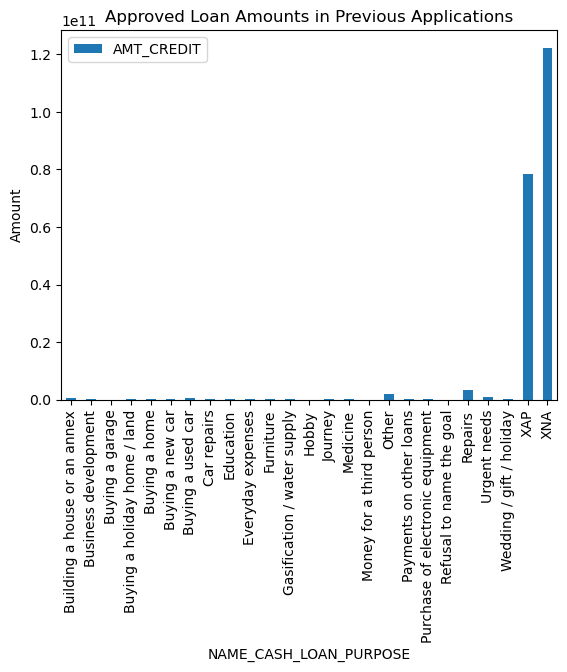

In [43]:
previousapp = datasets["previous_application"]

previousapp = previousapp[['SK_ID_CURR', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT','AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE' ]] 
previousapp['LoantoValue'] = previousapp['AMT_CREDIT'] / previousapp['AMT_GOODS_PRICE']
approvedapps = previousapp[previousapp['NAME_CONTRACT_STATUS'] == 'Approved'] 
refuseddapps = previousapp[previousapp['NAME_CONTRACT_STATUS'] == 'Refused'] 
approvedsum = approvedapps.groupby('NAME_CASH_LOAN_PURPOSE', as_index=False ).sum()
refusedsum = refuseddapps.groupby('NAME_CASH_LOAN_PURPOSE', as_index=False ).sum()
approvedsum.plot.bar(x='NAME_CASH_LOAN_PURPOSE', y=['AMT_CREDIT'],xlabel="NAME_CASH_LOAN_PURPOSE", ylabel = 'Amount',title='Approved Loan Amounts in Previous Applications',stacked=True);


In [44]:
previousapp = datasets["previous_application"]
previousapp['NAME_PORTFOLIO'].unique()

array(['POS', 'Cash', 'XNA', 'Cards', 'Cars'], dtype=object)

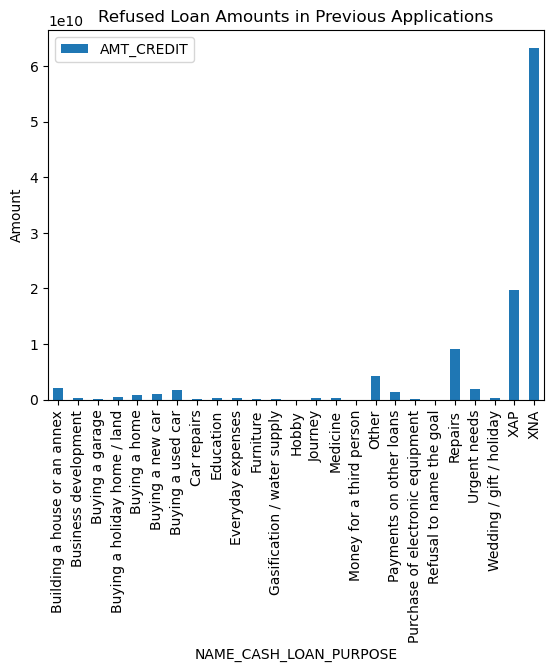

In [45]:
refusedsum.plot.bar(x='NAME_CASH_LOAN_PURPOSE', y=['AMT_CREDIT'],xlabel="NAME_CASH_LOAN_PURPOSE", ylabel = 'Amount',title='Refused Loan Amounts in Previous Applications',stacked=True);


In [46]:
approvedapps = previousapp[previousapp['NAME_CONTRACT_STATUS'] == 'Approved'] 
refuseddapps = previousapp[previousapp['NAME_CONTRACT_STATUS'] == 'Refused'] 
approvedapps = approvedapps.groupby('SK_ID_CURR', as_index=False ).sum()
refuseddapps = refuseddapps.groupby('SK_ID_CURR', as_index=False ).sum()
approvedapps["ApprovedorRejected"] = 'Approved'
refuseddapps["ApprovedorRejected"] = 'Refused'

In [47]:
# concatenating df1 and df2 along rows
#new_application = pd.concat([approvedapps, refuseddapps], axis=0)
new_application1 = approvedapps.merge(refuseddapps, how='left', on='SK_ID_CURR')


In [48]:
new_application1= new_application1.fillna(0)

new_application1.head(10)


,SK_ID_CURR,SK_ID_PREV_x,AMT_ANNUITY_x,AMT_APPLICATION_x,AMT_CREDIT_x,AMT_DOWN_PAYMENT_x,AMT_GOODS_PRICE_x,HOUR_APPR_PROCESS_START_x,NFLAG_LAST_APPL_IN_DAY_x,RATE_DOWN_PAYMENT_x,...,DAYS_DECISION_y,SELLERPLACE_AREA_y,CNT_PAYMENT_y,DAYS_FIRST_DRAWING_y,DAYS_FIRST_DUE_y,DAYS_LAST_DUE_1ST_VERSION_y,DAYS_LAST_DUE_y,DAYS_TERMINATION_y,NFLAG_INSURED_ON_APPROVAL_y,ApprovedorRejected_y
0,100001,1369693,3951.000,24835.50,23787.0,2520.00,24835.50,13,1,0.104326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100002,1038818,9251.775,179055.00,179055.0,0.00,179055.00,9,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100003,6843451,169661.970,1306309.50,1452573.0,6885.00,1306309.50,44,3,0.100061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100004,1564014,5357.250,24282.00,20106.0,4860.00,24282.00,5,1,0.212008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,100005,2495675,4813.200,44617.50,40153.5,4464.00,44617.50,11,1,0.108964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,100006,9077882,109210.950,1761329.34,1718644.5,69680.34,1761329.34,72,5,0.326824,...,-181.0,-1.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,Refused
6,100007,12946871,73672.830,903181.50,999832.5,6781.50,903181.50,74,6,0.319033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,100008,7926245,63358.785,778509.00,813838.5,16645.50,778509.00,42,4,0.219152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,100009,13172584,70359.885,537192.00,490963.5,64422.00,537192.00,96,7,0.886216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,100010,2349489,27463.410,247212.00,260811.0,0.00,247212.00,16,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [49]:
X_train_MF = X_train_MF.merge(new_application1, how='left', on='SK_ID_CURR')
X_test_MF = X_test_MF.merge(new_application1, how='left', on='SK_ID_CURR')
X_train_MF.iloc[:,126:]= X_train_MF.iloc[:,126:].fillna(0)
X_test_MF.iloc[:,125:]= X_test_MF.iloc[:,125:].fillna(0)
print(X_train_MF.shape)
print(X_test_MF.shape)
X_train_MF.head()

(307511, 168)
(48744, 167)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_DECISION_y,SELLERPLACE_AREA_y,CNT_PAYMENT_y,DAYS_FIRST_DRAWING_y,DAYS_FIRST_DUE_y,DAYS_LAST_DUE_1ST_VERSION_y,DAYS_LAST_DUE_y,DAYS_TERMINATION_y,NFLAG_INSURED_ON_APPROVAL_y,ApprovedorRejected_y
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-181.0,-1.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,Refused
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [50]:

bureauDF = datasets["bureau"]
bureauDFActive = bureauDF[bureauDF['CREDIT_ACTIVE'] == 'Active'] 
bureau_avg = bureauDFActive.groupby('SK_ID_CURR', as_index=False ).sum()

drop_list = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','CNT_CREDIT_PROLONG','DAYS_CREDIT_UPDATE']
bureau_avg.drop(drop_list,axis=1, inplace=True)



bureau_avg

,SK_ID_CURR,SK_ID_BUREAU,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY
0,100001,17689905,0.000,884025.000,596686.500,0.000,0.0,24817.500
1,100002,12317812,40.500,481988.565,245781.000,31988.565,0.0,0.000
2,100003,5885880,0.000,810000.000,0.000,810000.000,0.0,0.000
3,100005,13470403,0.000,598626.000,568408.500,0.000,0.0,4261.500
4,100008,6491434,0.000,267606.000,240057.000,0.000,0.0,0.000
...,...,...,...,...,...,...,...,...
251810,456247,18662546,24925.500,4113000.000,2193390.000,0.000,0.0,4329.000
251811,456249,10743399,0.000,405000.000,163071.000,0.000,0.0,0.000
251812,456250,13634475,0.000,2603110.050,2232040.095,58268.385,0.0,79556.895
251813,456253,11343077,0.000,2610000.000,1795833.000,0.000,0.0,58369.500


In [51]:
bureau_avg['ACTIVE_CLOSED_SUM_BUREAU'] = 'ACTIVE'

In [52]:
bureauDF = datasets["bureau"]
bureauDFClosed = bureauDF[bureauDF['CREDIT_ACTIVE'] == 'Closed'] 
bureauDFClosed = bureauDFClosed.groupby('SK_ID_CURR', as_index=False ).sum()

drop_list = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','CNT_CREDIT_PROLONG','DAYS_CREDIT_UPDATE']
bureauDFClosed.drop(drop_list,axis=1, inplace=True)



bureauDFClosed

,SK_ID_CURR,SK_ID_BUREAU,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY
0,100001,23586526,0.000,569340.00,0.0,0.0,0.0,0.0
1,100002,36908365,8364.645,383067.00,0.0,0.0,0.0,0.0
2,100003,17657634,0.000,207400.50,0.0,0.0,0.0,0.0
3,100004,13658267,0.000,189037.80,0.0,0.0,0.0,0.0
4,100005,6735200,0.000,58500.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
267920,456249,59088701,30735.000,3288858.66,0.0,0.0,0.0,0.0
267921,456250,6817236,0.000,483349.50,0.0,0.0,0.0,384147.0
267922,456253,12196997,0.000,1350000.00,0.0,0.0,0.0,116739.0
267923,456254,6669849,0.000,45000.00,0.0,0.0,0.0,0.0


In [53]:
bureauDFClosed['ACTIVE_CLOSED_SUM_BUREAU'] = 'CLOSED'

In [54]:
new_bureau1 = bureau_avg.merge(bureauDFClosed, how='left', on='SK_ID_CURR')


In [55]:
X_train_MF = X_train_MF.merge(new_bureau1, how='left', on='SK_ID_CURR')
X_test_MF = X_test_MF.merge(new_bureau1, how='left', on='SK_ID_CURR')
X_train_MF.iloc[:,168:]= X_train_MF.iloc[:,168:].fillna(0)
X_test_MF.iloc[:,167:]= X_test_MF.iloc[:,167:].fillna(0)
print(X_train_MF.shape)
print(X_test_MF.shape)

(307511, 184)
(48744, 183)


In [56]:
creditcarddf = datasets["credit_card_balance"]

creditcarddf = creditcarddf[['SK_ID_CURR', 'NAME_CONTRACT_STATUS','AMT_BALANCE', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE' ]] 
creditcarddf["Net_Outstanding_Credit_Card_Balance"] = creditcarddf['AMT_TOTAL_RECEIVABLE'] - creditcarddf['AMT_PAYMENT_TOTAL_CURRENT']
creditcarddf["Net_Outstanding_Credit_Card_Balance"] = creditcarddf["Net_Outstanding_Credit_Card_Balance"].fillna(0)
creditcarddf = creditcarddf.groupby('SK_ID_CURR', as_index=False ).sum()
X_train_MF = X_train_MF.merge(creditcarddf, how='left', on='SK_ID_CURR')
X_test_MF = X_test_MF.merge(creditcarddf, how='left', on='SK_ID_CURR')
X_train_MF.iloc[:,184:]= X_train_MF.iloc[:,184:].fillna(0)
X_test_MF.iloc[:,183:]= X_test_MF.iloc[:,183:].fillna(0)
print(X_train_MF.shape)
print(X_test_MF.shape)

(307511, 191)
(48744, 190)


In [57]:
bureauDF = datasets["bureau"]
credittype = bureauDF[bureauDF['CREDIT_ACTIVE'] == 'Active'] 
credittype = bureauDF.groupby('CREDIT_TYPE', as_index=False ).sum()

drop_list = ['SK_ID_CURR', 'SK_ID_BUREAU','DAYS_CREDIT','CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE','CNT_CREDIT_PROLONG']
credittype.drop(drop_list,axis=1, inplace=True)


credittype

,CREDIT_TYPE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY
0,Another type of loan,2.156163e+06,3.541248e+08,1.011144e+08,0.000000e+00,8.896500e+03,5.419597e+06
1,Car loan,1.587289e+08,5.050422e+10,1.252935e+10,9.877018e+05,2.837768e+06,3.046971e+08
2,Cash loan (non-earmarked),8.325243e+04,3.032160e+07,1.989405e+07,0.000000e+00,0.000000e+00,5.474923e+05
3,Consumer credit,1.519558e+09,3.831336e+11,1.051666e+11,6.402438e+06,4.221771e+07,5.499475e+09
4,Credit card,2.463525e+08,6.936593e+10,2.802179e+10,6.998621e+09,1.752653e+07,1.355389e+09
5,Interbank credit,0.000000e+00,1.350000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,Loan for business development,2.337014e+07,2.887729e+09,3.849363e+08,0.000000e+00,1.389017e+06,2.359162e+07
7,Loan for purchase of shares (margin lending),0.000000e+00,1.333800e+07,0.000000e+00,0.000000e+00,0.000000e+00,4.686849e+04
8,Loan for the purchase of equipment,1.248750e+05,8.422561e+07,8.538800e+06,0.000000e+00,0.000000e+00,2.214510e+05
9,Loan for working capital replenishment,1.500059e+05,7.312721e+08,1.074274e+08,0.000000e+00,3.924900e+04,3.797073e+06


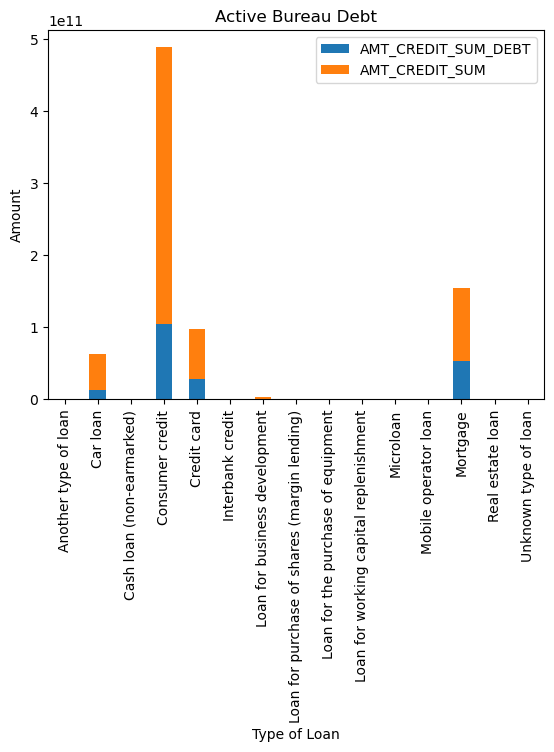

In [58]:
credittype.plot.bar(x='CREDIT_TYPE', y=['AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM'],xlabel="Type of Loan", ylabel = 'Amount',title='Active Bureau Debt',stacked=True);

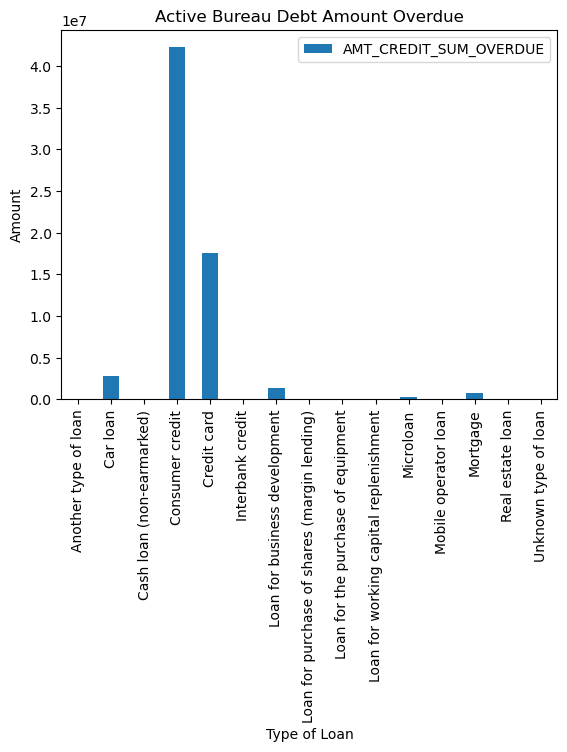

In [59]:
credittype.plot.bar(x='CREDIT_TYPE', y=['AMT_CREDIT_SUM_OVERDUE'],xlabel="Type of Loan", ylabel = 'Amount',title='Active Bureau Debt Amount Overdue',stacked=True);

In [60]:
installpayments = datasets["installments_payments"]
installpayments["Balance"]  = installpayments['AMT_INSTALMENT'] - installpayments['AMT_PAYMENT'] 
installpayments["Balance"] = installpayments["Balance"].fillna(0)
#installpayments[installpayments['Balance'] > 0].head(10)    
installpayments = installpayments.groupby('SK_ID_CURR', as_index=False ).sum()
X_train_MF = X_train_MF.merge(installpayments, how='left', on='SK_ID_CURR')
X_test_MF = X_test_MF.merge(installpayments, how='left', on='SK_ID_CURR')
X_train_MF.iloc[:,191:]= X_train_MF.iloc[:,191:].fillna(0)
X_test_MF.iloc[:,190:]= X_test_MF.iloc[:,190:].fillna(0)
print(X_train_MF.shape)
print(X_test_MF.shape)

(307511, 199)
(48744, 198)


In [61]:
X_train_MF['LoanToValue'] = X_train_MF['AMT_CREDIT'] / X_train_MF['AMT_GOODS_PRICE']
X_test_MF['LoanToValue'] = X_test_MF['AMT_CREDIT'] / X_test_MF['AMT_GOODS_PRICE']

In [62]:
print(X_train_MF.shape)
X_train_MF.head()

(307511, 200)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,Net_Outstanding_Credit_Card_Balance,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,Balance,LoanToValue
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,19737542.0,20.0,190.0,-5605.0,-5993.0,219625.695,219625.695,0.000,1.158397
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,57251754.0,26.0,127.0,-34454.0,-34633.0,1618864.650,1618864.650,0.000,1.145199
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,4692042.0,4.0,6.0,-2262.0,-2285.0,21288.465,21288.465,0.000,1.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,35478848.0,18.0,71.0,-4036.0,-4346.0,1007153.415,1007153.415,0.000,1.052803
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,135233040.0,77.0,465.0,-67888.0,-68128.0,835985.340,806127.975,29857.365,1.000000


In [63]:
print(X_test_MF.shape)
X_test_MF.head()

(48744, 199)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,Net_Outstanding_Credit_Card_Balance,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,Balance,LoanToValue
0,100001,Cash loans,F,False,True,0,135000.0,568800.0,20560.5,450000.0,...,0.000,11034724.0,8.0,19.0,-15314.0,-15365.0,41195.925,41195.925,0.000,1.2640
1,100005,Cash loans,M,False,True,0,99000.0,222768.0,17370.0,180000.0,...,0.000,22461075.0,10.0,45.0,-5274.0,-5486.0,56161.845,56161.845,0.000,1.2376
2,100013,Cash loans,M,True,True,0,202500.0,663264.0,69777.0,630000.0,...,1083255.120,296337140.0,43.0,6778.0,-209704.0,-210507.0,1689174.270,1509736.545,179437.725,1.0528
3,100028,Cash loans,F,False,True,2,315000.0,1575000.0,49018.5,1575000.0,...,115760.385,239050520.0,52.0,3447.0,-96677.0,-97016.0,562658.895,492310.665,70348.230,1.0000
4,100038,Cash loans,M,True,False,1,180000.0,625500.0,32067.0,625500.0,...,0.000,27935160.0,12.0,78.0,-7464.0,-7611.0,133204.050,133204.050,0.000,1.0000


# Feature engineering- **Recency**

**Data Description** 

A number of time related features were present in the secondary datasets. Recency or how time relates to a customer or client can sometimes be a helpful indicator in someone's value as a customer. To help determine which time based features would be most helpful in determining a client's creditworthiness, we aggregated time features using transformations such as mean, median, min, max, and sum. Once we had these values, we generated correlation values compared to the target feature. For each time related feature we used the most correlated aggregation as a new feature for our model. 

From the bureau dataset we created the features mean days credit, mean credit day overdue, total days credit enddate, minimum days enddate fact, and mean days credit update. From the POS Cash Balance dataset we created minimum months balance, minimum days past due, and maximum days past due with tolerance (low loan amounts ignored). From the credit card balance dataset we created median months balance, maximum days past due, and maximum days past due with tolerance (low loan amounts ignored). From the previous application dataset we created minimum days decision, mean days first drawing, maximum days first due, median days last due first, median days last due last, and median days termination of previous application. From installments payments we created minimum days installment, and minimum days entry payment. 


In [64]:
#save dfs for editing
bureauAC = datasets["bureau"]
bureau_balanceAC = datasets["bureau_balance"]
POS_CASH_balanceAC = datasets["POS_CASH_balance"]
credit_card_balanceAC = datasets["credit_card_balance"]
previous_applicationAC = datasets["previous_application"]
installments_paymentsAC = datasets["installments_payments"]

In [65]:
#rename columns to be unique where needed
#df1 = df.rename(columns={'Name': 'EmpName'})
bureau_balanceAC  = bureau_balanceAC.rename(columns={'MONTHS_BALANCE':'bb_MONTHS_BALANCE'})
POS_CASH_balanceAC  = POS_CASH_balanceAC.rename(columns={'MONTHS_BALANCE':'pos_MONTHS_BALANCE'})
credit_card_balanceAC  = credit_card_balanceAC.rename(columns={'MONTHS_BALANCE':'cc_MONTHS_BALANCE'})
POS_CASH_balanceAC  = POS_CASH_balanceAC.rename(columns={'SK_DPD':'pos_SK_DPD'})
credit_card_balanceAC  = credit_card_balanceAC.rename(columns={'SK_DPD':'cc_SK_DPD'})
POS_CASH_balanceAC  = POS_CASH_balanceAC.rename(columns={'SK_DPD_DEF':'pos_SK_DPD_DEF'})
credit_card_balanceAC  = credit_card_balanceAC.rename(columns={'SK_DPD_DEF':'cc_SK_DPD_DEF'})

In [66]:
#keep only time based features in dfs
bureauAC.drop(bureauAC.columns.difference(['SK_ID_CURR','DAYS_CREDIT','CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE']),1,inplace=True)
#bureau_balanceAC = bureau_balanceAC
POS_CASH_balanceAC.drop(POS_CASH_balanceAC.columns.difference(['SK_ID_CURR','pos_MONTHS_BALANCE','pos_SK_DPD','pos_SK_DPD_DEF']),1,inplace=True)
credit_card_balanceAC.drop(credit_card_balanceAC.columns.difference(['SK_ID_CURR','cc_MONTHS_BALANCE','cc_SK_DPD','cc_SK_DPD_DEF']),1,inplace=True)
previous_applicationAC.drop(previous_applicationAC.columns.difference(['SK_ID_CURR','DAYS_DECISION','DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']),1,inplace=True)
installments_paymentsAC.drop(installments_paymentsAC.columns.difference(['SK_ID_CURR','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT']),1,inplace=True)


## Mean

In [67]:
# setup variables for application_train dataset
application_train = datasets["application_train"]
X_trainFEmean = []
X_trainFEmean = application_train
X_trainFEmean.set_index('SK_ID_CURR')
X_trainFEmean = X_trainFEmean[['SK_ID_CURR','TARGET']]
X_trainFEmean.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [68]:
#merging time based dfs with xtrain data to use target values for correlation
bureauAC_mean = bureauAC.groupby('SK_ID_CURR', as_index=False ).mean()
X_trainFEmean = X_trainFEmean.merge(bureauAC_mean, how='left', on='SK_ID_CURR')
POS_CASH_balanceAC_mean = POS_CASH_balanceAC.groupby('SK_ID_CURR', as_index=False ).mean()
X_trainFEmean = X_trainFEmean.merge(POS_CASH_balanceAC_mean, how='left', on='SK_ID_CURR')
credit_card_balanceAC_mean = credit_card_balanceAC.groupby('SK_ID_CURR', as_index=False ).mean()
X_trainFEmean = X_trainFEmean.merge(credit_card_balanceAC_mean, how='left', on='SK_ID_CURR')
previous_applicationAC_mean = previous_applicationAC.groupby('SK_ID_CURR', as_index=False ).mean()
X_trainFEmean = X_trainFEmean.merge(previous_applicationAC_mean, how='left', on='SK_ID_CURR')
installments_paymentsAC_mean = installments_paymentsAC.groupby('SK_ID_CURR', as_index=False ).mean()
X_trainFEmean = X_trainFEmean.merge(installments_paymentsAC_mean, how='left', on='SK_ID_CURR')

In [69]:
meancor=X_trainFEmean.corr()['TARGET'].sort_values()
meancor

DAYS_FIRST_DRAWING          -0.048803
DAYS_FIRST_DUE              -0.009334
cc_SK_DPD                   -0.003195
SK_ID_CURR                  -0.002108
pos_SK_DPD                   0.005436
pos_SK_DPD_DEF               0.006496
cc_SK_DPD_DEF                0.006660
CREDIT_DAY_OVERDUE           0.008118
DAYS_TERMINATION             0.025795
DAYS_LAST_DUE                0.026923
DAYS_LAST_DUE_1ST_VERSION    0.031203
pos_MONTHS_BALANCE           0.034543
DAYS_INSTALMENT              0.043509
DAYS_ENTRY_PAYMENT           0.043992
DAYS_DECISION                0.046864
DAYS_CREDIT_ENDDATE          0.046983
DAYS_ENDDATE_FACT            0.053200
cc_MONTHS_BALANCE            0.062081
DAYS_CREDIT_UPDATE           0.068927
DAYS_CREDIT                  0.089729
TARGET                       1.000000
Name: TARGET, dtype: float64

## Median

In [70]:
# setup variables for application_train dataset
application_train = datasets["application_train"]
X_trainFEmed = []
X_trainFEmed = application_train
X_trainFEmed.set_index('SK_ID_CURR')
X_trainFEmed = X_trainFEmed[['SK_ID_CURR','TARGET']]
X_trainFEmed.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [71]:
#merging time based dfs with xtrain data to use target values for correlation
bureauAC_med = bureauAC.groupby('SK_ID_CURR', as_index=False ).median()
X_trainFEmed = X_trainFEmed.merge(bureauAC_med, how='left', on='SK_ID_CURR')
POS_CASH_balanceAC_med = POS_CASH_balanceAC.groupby('SK_ID_CURR', as_index=False ).median()
X_trainFEmed = X_trainFEmed.merge(POS_CASH_balanceAC_med, how='left', on='SK_ID_CURR')
credit_card_balanceAC_med = credit_card_balanceAC.groupby('SK_ID_CURR', as_index=False ).median()
X_trainFEmed = X_trainFEmed.merge(credit_card_balanceAC_med, how='left', on='SK_ID_CURR')
previous_applicationAC_med = previous_applicationAC.groupby('SK_ID_CURR', as_index=False ).median()
X_trainFEmed = X_trainFEmed.merge(previous_applicationAC_med, how='left', on='SK_ID_CURR')
installments_paymentsAC_med = installments_paymentsAC.groupby('SK_ID_CURR', as_index=False ).median()
X_trainFEmed = X_trainFEmed.merge(installments_paymentsAC_med, how='left', on='SK_ID_CURR')

In [72]:
medcor=X_trainFEmed.corr()['TARGET'].sort_values()
medcor

DAYS_FIRST_DRAWING          -0.038551
SK_ID_CURR                  -0.002108
cc_SK_DPD                    0.002261
pos_SK_DPD                   0.005442
pos_SK_DPD_DEF               0.005636
DAYS_FIRST_DUE               0.006470
cc_SK_DPD_DEF                0.006669
CREDIT_DAY_OVERDUE           0.007847
pos_MONTHS_BALANCE           0.027833
DAYS_TERMINATION             0.031798
DAYS_LAST_DUE_1ST_VERSION    0.032637
DAYS_LAST_DUE                0.032807
DAYS_INSTALMENT              0.039252
DAYS_ENTRY_PAYMENT           0.039654
DAYS_CREDIT_ENDDATE          0.039929
DAYS_DECISION                0.040164
DAYS_ENDDATE_FACT            0.050603
cc_MONTHS_BALANCE            0.062192
DAYS_CREDIT_UPDATE           0.067338
DAYS_CREDIT                  0.085414
TARGET                       1.000000
Name: TARGET, dtype: float64

## Min

In [73]:
# setup variables for application_train dataset
application_train = datasets["application_train"]
X_trainFEmin = []
X_trainFEmin = application_train
X_trainFEmin.set_index('SK_ID_CURR')
X_trainFEmin = X_trainFEmin[['SK_ID_CURR','TARGET']]
X_trainFEmin.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [74]:
#merging time based dfs with xtrain data to use target values for correlation
bureauAC_min = bureauAC.groupby('SK_ID_CURR', as_index=False ).min()
X_trainFEmin = X_trainFEmin.merge(bureauAC_min, how='left', on='SK_ID_CURR')
POS_CASH_balanceAC_min = POS_CASH_balanceAC.groupby('SK_ID_CURR', as_index=False ).min()
X_trainFEmin = X_trainFEmin.merge(POS_CASH_balanceAC_min, how='left', on='SK_ID_CURR')
credit_card_balanceAC_min = credit_card_balanceAC.groupby('SK_ID_CURR', as_index=False ).min()
X_trainFEmin = X_trainFEmin.merge(credit_card_balanceAC_min, how='left', on='SK_ID_CURR')
previous_applicationAC_min = previous_applicationAC.groupby('SK_ID_CURR', as_index=False ).min()
X_trainFEmin = X_trainFEmin.merge(previous_applicationAC_min, how='left', on='SK_ID_CURR')
installments_paymentsAC_min = installments_paymentsAC.groupby('SK_ID_CURR', as_index=False ).min()
X_trainFEmin = X_trainFEmin.merge(installments_paymentsAC_min, how='left', on='SK_ID_CURR')

In [75]:
mincor=X_trainFEmin.corr()['TARGET'].sort_values()
mincor

DAYS_FIRST_DRAWING          -0.044643
SK_ID_CURR                  -0.002108
pos_SK_DPD_DEF               0.004702
pos_SK_DPD                   0.005444
DAYS_FIRST_DUE               0.006042
CREDIT_DAY_OVERDUE           0.007573
DAYS_LAST_DUE_1ST_VERSION    0.014645
DAYS_TERMINATION             0.025605
DAYS_LAST_DUE                0.026186
DAYS_CREDIT_ENDDATE          0.034281
DAYS_CREDIT_UPDATE           0.042864
DAYS_DECISION                0.053434
pos_MONTHS_BALANCE           0.055307
DAYS_ENDDATE_FACT            0.055887
DAYS_INSTALMENT              0.058648
DAYS_ENTRY_PAYMENT           0.058794
cc_MONTHS_BALANCE            0.061359
DAYS_CREDIT                  0.075248
TARGET                       1.000000
cc_SK_DPD                         NaN
cc_SK_DPD_DEF                     NaN
Name: TARGET, dtype: float64

## Max

In [76]:
# setup variables for application_train dataset
application_train = datasets["application_train"]
X_trainFEmax = []
X_trainFEmax = application_train
X_trainFEmax.set_index('SK_ID_CURR')
X_trainFEmax = X_trainFEmax[['SK_ID_CURR','TARGET']]
X_trainFEmax.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [77]:
#merging time based dfs with xtrain data to use target values for correlation
bureauAC_max = bureauAC.groupby('SK_ID_CURR', as_index=False ).max()
X_trainFEmax = X_trainFEmax.merge(bureauAC_max, how='left', on='SK_ID_CURR')
POS_CASH_balanceAC_max = POS_CASH_balanceAC.groupby('SK_ID_CURR', as_index=False ).max()
X_trainFEmax = X_trainFEmax.merge(POS_CASH_balanceAC_max, how='left', on='SK_ID_CURR')
credit_card_balanceAC_max = credit_card_balanceAC.groupby('SK_ID_CURR', as_index=False ).max()
X_trainFEmax = X_trainFEmax.merge(credit_card_balanceAC_max, how='left', on='SK_ID_CURR')
previous_applicationAC_max = previous_applicationAC.groupby('SK_ID_CURR', as_index=False ).max()
X_trainFEmax = X_trainFEmax.merge(previous_applicationAC_max, how='left', on='SK_ID_CURR')
installments_paymentsAC_max = installments_paymentsAC.groupby('SK_ID_CURR', as_index=False ).max()
X_trainFEmax = X_trainFEmax.merge(installments_paymentsAC_max, how='left', on='SK_ID_CURR')

In [78]:
maxcor=X_trainFEmax.corr()['TARGET'].sort_values()
maxcor

DAYS_FIRST_DUE              -0.020158
DAYS_FIRST_DRAWING          -0.015053
cc_SK_DPD                   -0.005975
pos_MONTHS_BALANCE          -0.004321
DAYS_INSTALMENT             -0.003231
DAYS_ENTRY_PAYMENT          -0.002298
SK_ID_CURR                  -0.002108
pos_SK_DPD                   0.004763
DAYS_TERMINATION             0.005217
CREDIT_DAY_OVERDUE           0.005493
DAYS_LAST_DUE                0.006689
cc_SK_DPD_DEF                0.007089
pos_SK_DPD_DEF               0.009580
DAYS_DECISION                0.016399
DAYS_LAST_DUE_1ST_VERSION    0.019065
DAYS_ENDDATE_FACT            0.019644
cc_MONTHS_BALANCE            0.025251
DAYS_CREDIT_UPDATE           0.028234
DAYS_CREDIT_ENDDATE          0.036590
DAYS_CREDIT                  0.049782
TARGET                       1.000000
Name: TARGET, dtype: float64

## Sum

In [79]:
# setup variables for application_train dataset
application_train = datasets["application_train"]
X_trainFEsum = []
X_trainFEsum = application_train
X_trainFEsum.set_index('SK_ID_CURR')
X_trainFEsum = X_trainFEsum[['SK_ID_CURR','TARGET']]
X_trainFEsum.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [80]:
#merging time based dfs with xtrain data to use target values for correlation
bureauAC_sum = bureauAC.groupby('SK_ID_CURR', as_index=False ).sum()
X_trainFEsum = X_trainFEsum.merge(bureauAC_sum, how='left', on='SK_ID_CURR')
POS_CASH_balanceAC_sum = POS_CASH_balanceAC.groupby('SK_ID_CURR', as_index=False ).sum()
X_trainFEsum = X_trainFEsum.merge(POS_CASH_balanceAC_sum, how='left', on='SK_ID_CURR')
credit_card_balanceAC_sum = credit_card_balanceAC.groupby('SK_ID_CURR', as_index=False ).sum()
X_trainFEsum = X_trainFEsum.merge(credit_card_balanceAC_sum, how='left', on='SK_ID_CURR')
previous_applicationAC_sum = previous_applicationAC.groupby('SK_ID_CURR', as_index=False ).sum()
X_trainFEsum = X_trainFEsum.merge(previous_applicationAC_sum, how='left', on='SK_ID_CURR')
installments_paymentsAC_sum = installments_paymentsAC.groupby('SK_ID_CURR', as_index=False ).sum()
X_trainFEsum = X_trainFEsum.merge(installments_paymentsAC_sum, how='left', on='SK_ID_CURR')

In [81]:
sumcor=X_trainFEsum.corr()['TARGET'].sort_values()
sumcor

DAYS_FIRST_DRAWING          -0.041671
DAYS_FIRST_DUE              -0.018361
cc_SK_DPD                   -0.003566
SK_ID_CURR                  -0.002108
pos_SK_DPD                   0.004740
pos_SK_DPD_DEF               0.004950
CREDIT_DAY_OVERDUE           0.006298
cc_SK_DPD_DEF                0.006972
DAYS_TERMINATION             0.007552
DAYS_LAST_DUE                0.009197
DAYS_DECISION                0.019698
DAYS_LAST_DUE_1ST_VERSION    0.019977
DAYS_INSTALMENT              0.035064
DAYS_ENTRY_PAYMENT           0.035227
pos_MONTHS_BALANCE           0.040570
DAYS_CREDIT_UPDATE           0.041404
DAYS_CREDIT                  0.042000
DAYS_ENDDATE_FACT            0.048854
DAYS_CREDIT_ENDDATE          0.053735
cc_MONTHS_BALANCE            0.059051
TARGET                       1.000000
Name: TARGET, dtype: float64

## Comparison

In [82]:
#save correlation results as dfs
meancor = pd.DataFrame(meancor)
medcor = pd.DataFrame(medcor)
mincor = pd.DataFrame(mincor)
maxcor = pd.DataFrame(maxcor)
sumcor = pd.DataFrame(sumcor)

In [83]:
#set indexes on correlation dfs
meancor.index.name = 'feature'
medcor.index.name = 'feature'
mincor.index.name = 'feature'
maxcor.index.name = 'feature'
sumcor.index.name = 'feature'


In [84]:
#renaming columns in each df to represent the transformation taken
meancor.rename(columns={'TARGET': 'mean_cor'}, inplace=True)
medcor.rename(columns={'TARGET': 'med_cor'}, inplace=True)
mincor.rename(columns={'TARGET': 'min_cor'}, inplace=True)
maxcor.rename(columns={'TARGET': 'max_cor'}, inplace=True)
sumcor.rename(columns={'TARGET': 'sum_cor'}, inplace=True)

In [85]:
#creating one df with all correlation values
cortable = meancor
cortable = cortable.merge(medcor, how='left', on='feature')
cortable = cortable.merge(mincor, how='left', on='feature')
cortable = cortable.merge(maxcor, how='left', on='feature')
cortable = cortable.merge(sumcor, how='left', on='feature')
cortable = cortable.abs()
cortable

,mean_cor,med_cor,min_cor,max_cor,sum_cor
feature,,,,,
DAYS_FIRST_DRAWING,0.048803,0.038551,0.044643,0.015053,0.041671
DAYS_FIRST_DUE,0.009334,0.006470,0.006042,0.020158,0.018361
cc_SK_DPD,0.003195,0.002261,NaN,0.005975,0.003566
SK_ID_CURR,0.002108,0.002108,0.002108,0.002108,0.002108
pos_SK_DPD,0.005436,0.005442,0.005444,0.004763,0.004740
pos_SK_DPD_DEF,0.006496,0.005636,0.004702,0.009580,0.004950
cc_SK_DPD_DEF,0.006660,0.006669,NaN,0.007089,0.006972
CREDIT_DAY_OVERDUE,0.008118,0.007847,0.007573,0.005493,0.006298
DAYS_TERMINATION,0.025795,0.031798,0.025605,0.005217,0.007552


In [86]:
#checking which columns have the highest correlation for each feature
cortable.idxmax(axis=1)

feature
DAYS_FIRST_DRAWING           mean_cor
DAYS_FIRST_DUE                max_cor
cc_SK_DPD                     max_cor
SK_ID_CURR                   mean_cor
pos_SK_DPD                    min_cor
pos_SK_DPD_DEF                max_cor
cc_SK_DPD_DEF                 max_cor
CREDIT_DAY_OVERDUE           mean_cor
DAYS_TERMINATION              med_cor
DAYS_LAST_DUE                 med_cor
DAYS_LAST_DUE_1ST_VERSION     med_cor
pos_MONTHS_BALANCE            min_cor
DAYS_INSTALMENT               min_cor
DAYS_ENTRY_PAYMENT            min_cor
DAYS_DECISION                 min_cor
DAYS_CREDIT_ENDDATE           sum_cor
DAYS_ENDDATE_FACT             min_cor
cc_MONTHS_BALANCE             med_cor
DAYS_CREDIT_UPDATE           mean_cor
DAYS_CREDIT                  mean_cor
TARGET                       mean_cor
dtype: object

## Joining FE Columns

In [87]:
# setup variables for application_train dataset
application_train = datasets["application_train"]
X_trainAC = []
X_trainAC = application_train
X_trainAC.set_index('SK_ID_CURR')
X_trainAC.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# setup variables for application_test dataset
application_test = datasets["application_test"]
X_kaggle_testAC = []
X_kaggle_testAC = application_test
X_kaggle_testAC.set_index('SK_ID_CURR')
X_kaggle_testAC.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
#joining test and train to get complete list of IDs
rfeat = X_trainAC.append(X_kaggle_testAC)

In [90]:
#checking that ID's from both test and train are present. They are!
rfeat.sort_values(by=['SK_ID_CURR'])

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,NaN,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,NaN,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0.0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0.0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1.0,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
#drop all but the ID and Target columns
rfeat.drop(rfeat.columns.difference(['SK_ID_CURR','TARGET']), 1, inplace=True)

In [92]:
rfeat = rfeat.sort_values(by=['SK_ID_CURR'])
rfeat

,SK_ID_CURR,TARGET
0,100001,NaN
0,100002,1.0
1,100003,0.0
2,100004,0.0
1,100005,NaN
...,...,...
307506,456251,0.0
307507,456252,0.0
307508,456253,0.0
307509,456254,1.0


In [93]:
#adding the most correlated feature transformations to create a DF with recency features worth joining to the primary data
rfeat = pd.merge(rfeat,bureauAC_mean[['SK_ID_CURR','DAYS_CREDIT','CREDIT_DAY_OVERDUE','DAYS_CREDIT_UPDATE']],on='SK_ID_CURR', how='left')
rfeat = pd.merge(rfeat,bureauAC_sum[['SK_ID_CURR','DAYS_CREDIT_ENDDATE']],on='SK_ID_CURR', how='left')
rfeat = pd.merge(rfeat,bureauAC_min[['SK_ID_CURR','DAYS_ENDDATE_FACT']],on='SK_ID_CURR', how='left')

rfeat = pd.merge(rfeat,POS_CASH_balanceAC_min[['SK_ID_CURR','pos_MONTHS_BALANCE','pos_SK_DPD']],on='SK_ID_CURR', how='left')
rfeat = pd.merge(rfeat,POS_CASH_balanceAC_max[['SK_ID_CURR','pos_SK_DPD_DEF']],on='SK_ID_CURR', how='left')

rfeat = pd.merge(rfeat,credit_card_balanceAC_med[['SK_ID_CURR','cc_MONTHS_BALANCE']],on='SK_ID_CURR', how='left')
rfeat = pd.merge(rfeat,credit_card_balanceAC_max[['SK_ID_CURR','cc_SK_DPD','cc_SK_DPD_DEF']],on='SK_ID_CURR', how='left')

rfeat = pd.merge(rfeat,previous_applicationAC_min[['SK_ID_CURR','DAYS_DECISION']],on='SK_ID_CURR', how='left')
rfeat = pd.merge(rfeat,previous_applicationAC_mean[['SK_ID_CURR','DAYS_FIRST_DRAWING']],on='SK_ID_CURR', how='left')
rfeat = pd.merge(rfeat,previous_applicationAC_max[['SK_ID_CURR','DAYS_FIRST_DUE']],on='SK_ID_CURR', how='left')
rfeat = pd.merge(rfeat,previous_applicationAC_med[['SK_ID_CURR','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']],on='SK_ID_CURR', how='left')

rfeat = pd.merge(rfeat,installments_paymentsAC_min[['SK_ID_CURR','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT']],on='SK_ID_CURR', how='left')


rfeat

,SK_ID_CURR,TARGET,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,pos_MONTHS_BALANCE,pos_SK_DPD,pos_SK_DPD_DEF,...,cc_SK_DPD,cc_SK_DPD_DEF,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT
0,100001,NaN,-735.000000,0.0,-93.142857,577.0,-1328.0,-96.0,0.0,7.0,...,NaN,NaN,-1740.0,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,-2916.0,-2916.0
1,100002,1.0,-874.000000,0.0,-499.875000,-2094.0,-1185.0,-19.0,0.0,0.0,...,NaN,NaN,-606.0,365243.0,-565.0,125.0,-25.0,-17.0,-565.0,-587.0
2,100003,0.0,-1400.750000,0.0,-816.000000,-2178.0,-2131.0,-77.0,0.0,0.0,...,NaN,NaN,-2341.0,365243.0,-716.0,-647.0,-647.0,-639.0,-2310.0,-2324.0
3,100004,0.0,-867.000000,0.0,-532.000000,-977.0,-683.0,-27.0,0.0,0.0,...,NaN,NaN,-815.0,365243.0,-784.0,-694.0,-724.0,-714.0,-784.0,-795.0
4,100005,NaN,-190.666667,0.0,-54.333333,1318.0,-123.0,-25.0,0.0,0.0,...,NaN,NaN,-757.0,365243.0,-706.0,-376.0,-466.0,-460.0,-706.0,-736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456251,0.0,NaN,NaN,NaN,NaN,NaN,-9.0,0.0,0.0,...,NaN,NaN,-273.0,365243.0,-210.0,0.0,-30.0,-25.0,-210.0,-237.0
356251,456252,0.0,NaN,NaN,NaN,NaN,NaN,-82.0,0.0,0.0,...,NaN,NaN,-2497.0,365243.0,-2466.0,-2316.0,-2316.0,-2311.0,-2466.0,-2470.0
356252,456253,0.0,-867.500000,0.0,-253.250000,1122.0,-794.0,-96.0,0.0,5.0,...,NaN,NaN,-2851.0,365243.0,-1866.0,-2219.0,-2219.0,-2212.5,-2915.0,-2915.0
356253,456254,1.0,-1104.000000,0.0,-401.000000,-859.0,-859.0,-11.0,0.0,0.0,...,NaN,NaN,-322.0,365243.0,-247.0,151.0,365243.0,365243.0,-291.0,-317.0


In [94]:
#checking that correlations didn't change with incorporation of test data. They are the same as before
rfeat.corr()['TARGET'].sort_values()

DAYS_FIRST_DRAWING          -0.048803
DAYS_FIRST_DUE              -0.020158
cc_SK_DPD                   -0.005975
SK_ID_CURR                  -0.002108
pos_SK_DPD                   0.005444
cc_SK_DPD_DEF                0.007089
CREDIT_DAY_OVERDUE           0.008118
pos_SK_DPD_DEF               0.009580
DAYS_TERMINATION             0.031798
DAYS_LAST_DUE_1ST_VERSION    0.032637
DAYS_LAST_DUE                0.032807
DAYS_DECISION                0.053434
DAYS_CREDIT_ENDDATE          0.053735
pos_MONTHS_BALANCE           0.055307
DAYS_ENDDATE_FACT            0.055887
DAYS_INSTALMENT              0.058648
DAYS_ENTRY_PAYMENT           0.058794
cc_MONTHS_BALANCE            0.062192
DAYS_CREDIT_UPDATE           0.068927
DAYS_CREDIT                  0.089729
TARGET                       1.000000
Name: TARGET, dtype: float64

In [95]:
rfeat.drop(['TARGET'], 1, inplace= True)
rfeat

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,pos_MONTHS_BALANCE,pos_SK_DPD,pos_SK_DPD_DEF,cc_MONTHS_BALANCE,cc_SK_DPD,cc_SK_DPD_DEF,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT
0,100001,-735.000000,0.0,-93.142857,577.0,-1328.0,-96.0,0.0,7.0,NaN,NaN,NaN,-1740.0,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,-2916.0,-2916.0
1,100002,-874.000000,0.0,-499.875000,-2094.0,-1185.0,-19.0,0.0,0.0,NaN,NaN,NaN,-606.0,365243.0,-565.0,125.0,-25.0,-17.0,-565.0,-587.0
2,100003,-1400.750000,0.0,-816.000000,-2178.0,-2131.0,-77.0,0.0,0.0,NaN,NaN,NaN,-2341.0,365243.0,-716.0,-647.0,-647.0,-639.0,-2310.0,-2324.0
3,100004,-867.000000,0.0,-532.000000,-977.0,-683.0,-27.0,0.0,0.0,NaN,NaN,NaN,-815.0,365243.0,-784.0,-694.0,-724.0,-714.0,-784.0,-795.0
4,100005,-190.666667,0.0,-54.333333,1318.0,-123.0,-25.0,0.0,0.0,NaN,NaN,NaN,-757.0,365243.0,-706.0,-376.0,-466.0,-460.0,-706.0,-736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456251,NaN,NaN,NaN,NaN,NaN,-9.0,0.0,0.0,NaN,NaN,NaN,-273.0,365243.0,-210.0,0.0,-30.0,-25.0,-210.0,-237.0
356251,456252,NaN,NaN,NaN,NaN,NaN,-82.0,0.0,0.0,NaN,NaN,NaN,-2497.0,365243.0,-2466.0,-2316.0,-2316.0,-2311.0,-2466.0,-2470.0
356252,456253,-867.500000,0.0,-253.250000,1122.0,-794.0,-96.0,0.0,5.0,NaN,NaN,NaN,-2851.0,365243.0,-1866.0,-2219.0,-2219.0,-2212.5,-2915.0,-2915.0
356253,456254,-1104.000000,0.0,-401.000000,-859.0,-859.0,-11.0,0.0,0.0,NaN,NaN,NaN,-322.0,365243.0,-247.0,151.0,365243.0,365243.0,-291.0,-317.0


In [96]:
#fill NAs with 0s. Since this is time related features, using 0s seems to make sense since they have no time for these features.
rfeat = rfeat.fillna(0)
rfeat

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,pos_MONTHS_BALANCE,pos_SK_DPD,pos_SK_DPD_DEF,cc_MONTHS_BALANCE,cc_SK_DPD,cc_SK_DPD_DEF,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT
0,100001,-735.000000,0.0,-93.142857,577.0,-1328.0,-96.0,0.0,7.0,0.0,0.0,0.0,-1740.0,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,-2916.0,-2916.0
1,100002,-874.000000,0.0,-499.875000,-2094.0,-1185.0,-19.0,0.0,0.0,0.0,0.0,0.0,-606.0,365243.0,-565.0,125.0,-25.0,-17.0,-565.0,-587.0
2,100003,-1400.750000,0.0,-816.000000,-2178.0,-2131.0,-77.0,0.0,0.0,0.0,0.0,0.0,-2341.0,365243.0,-716.0,-647.0,-647.0,-639.0,-2310.0,-2324.0
3,100004,-867.000000,0.0,-532.000000,-977.0,-683.0,-27.0,0.0,0.0,0.0,0.0,0.0,-815.0,365243.0,-784.0,-694.0,-724.0,-714.0,-784.0,-795.0
4,100005,-190.666667,0.0,-54.333333,1318.0,-123.0,-25.0,0.0,0.0,0.0,0.0,0.0,-757.0,365243.0,-706.0,-376.0,-466.0,-460.0,-706.0,-736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456251,0.000000,0.0,0.000000,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,-273.0,365243.0,-210.0,0.0,-30.0,-25.0,-210.0,-237.0
356251,456252,0.000000,0.0,0.000000,0.0,0.0,-82.0,0.0,0.0,0.0,0.0,0.0,-2497.0,365243.0,-2466.0,-2316.0,-2316.0,-2311.0,-2466.0,-2470.0
356252,456253,-867.500000,0.0,-253.250000,1122.0,-794.0,-96.0,0.0,5.0,0.0,0.0,0.0,-2851.0,365243.0,-1866.0,-2219.0,-2219.0,-2212.5,-2915.0,-2915.0
356253,456254,-1104.000000,0.0,-401.000000,-859.0,-859.0,-11.0,0.0,0.0,0.0,0.0,0.0,-322.0,365243.0,-247.0,151.0,365243.0,365243.0,-291.0,-317.0


In [97]:
#rename all columns to be unique and prevent joining issues
rfeat.columns = [str(col) + '_FE' for col in rfeat.columns]

In [98]:
#revert SK_ID_CURR back to normal so it will join properly
rfeat = rfeat.rename(columns={"SK_ID_CURR_FE": "SK_ID_CURR"})
rfeat

,SK_ID_CURR,DAYS_CREDIT_FE,CREDIT_DAY_OVERDUE_FE,DAYS_CREDIT_UPDATE_FE,DAYS_CREDIT_ENDDATE_FE,DAYS_ENDDATE_FACT_FE,pos_MONTHS_BALANCE_FE,pos_SK_DPD_FE,pos_SK_DPD_DEF_FE,cc_MONTHS_BALANCE_FE,cc_SK_DPD_FE,cc_SK_DPD_DEF_FE,DAYS_DECISION_FE,DAYS_FIRST_DRAWING_FE,DAYS_FIRST_DUE_FE,DAYS_LAST_DUE_1ST_VERSION_FE,DAYS_LAST_DUE_FE,DAYS_TERMINATION_FE,DAYS_INSTALMENT_FE,DAYS_ENTRY_PAYMENT_FE
0,100001,-735.000000,0.0,-93.142857,577.0,-1328.0,-96.0,0.0,7.0,0.0,0.0,0.0,-1740.0,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,-2916.0,-2916.0
1,100002,-874.000000,0.0,-499.875000,-2094.0,-1185.0,-19.0,0.0,0.0,0.0,0.0,0.0,-606.0,365243.0,-565.0,125.0,-25.0,-17.0,-565.0,-587.0
2,100003,-1400.750000,0.0,-816.000000,-2178.0,-2131.0,-77.0,0.0,0.0,0.0,0.0,0.0,-2341.0,365243.0,-716.0,-647.0,-647.0,-639.0,-2310.0,-2324.0
3,100004,-867.000000,0.0,-532.000000,-977.0,-683.0,-27.0,0.0,0.0,0.0,0.0,0.0,-815.0,365243.0,-784.0,-694.0,-724.0,-714.0,-784.0,-795.0
4,100005,-190.666667,0.0,-54.333333,1318.0,-123.0,-25.0,0.0,0.0,0.0,0.0,0.0,-757.0,365243.0,-706.0,-376.0,-466.0,-460.0,-706.0,-736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456251,0.000000,0.0,0.000000,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,-273.0,365243.0,-210.0,0.0,-30.0,-25.0,-210.0,-237.0
356251,456252,0.000000,0.0,0.000000,0.0,0.0,-82.0,0.0,0.0,0.0,0.0,0.0,-2497.0,365243.0,-2466.0,-2316.0,-2316.0,-2311.0,-2466.0,-2470.0
356252,456253,-867.500000,0.0,-253.250000,1122.0,-794.0,-96.0,0.0,5.0,0.0,0.0,0.0,-2851.0,365243.0,-1866.0,-2219.0,-2219.0,-2212.5,-2915.0,-2915.0
356253,456254,-1104.000000,0.0,-401.000000,-859.0,-859.0,-11.0,0.0,0.0,0.0,0.0,0.0,-322.0,365243.0,-247.0,151.0,365243.0,365243.0,-291.0,-317.0


In [99]:
#joining feature engineered recency features to primary train and test data set
X_train_MF = X_train_MF.merge(rfeat, how='left', on='SK_ID_CURR')
X_test_MF = X_test_MF.merge(rfeat, how='left', on='SK_ID_CURR')


In [100]:
print(X_train_MF.shape)
X_train_MF.head()

(307511, 219)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_SK_DPD_FE,cc_SK_DPD_DEF_FE,DAYS_DECISION_FE,DAYS_FIRST_DRAWING_FE,DAYS_FIRST_DUE_FE,DAYS_LAST_DUE_1ST_VERSION_FE,DAYS_LAST_DUE_FE,DAYS_TERMINATION_FE,DAYS_INSTALMENT_FE,DAYS_ENTRY_PAYMENT_FE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,-606.0,365243.0,-565.0,125.0,-25.0,-17.0,-565.0,-587.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,-2341.0,365243.0,-716.0,-647.0,-647.0,-639.0,-2310.0,-2324.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,-815.0,365243.0,-784.0,-694.0,-724.0,-714.0,-784.0,-795.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,-617.0,365243.0,365243.0,654.0,182546.0,182550.0,-545.0,-575.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,-2357.0,365243.0,-344.0,-746.0,-746.0,-739.0,-2326.0,-2318.0


In [101]:
print(X_test_MF.shape)
X_test_MF.head()

(48744, 218)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_SK_DPD_FE,cc_SK_DPD_DEF_FE,DAYS_DECISION_FE,DAYS_FIRST_DRAWING_FE,DAYS_FIRST_DUE_FE,DAYS_LAST_DUE_1ST_VERSION_FE,DAYS_LAST_DUE_FE,DAYS_TERMINATION_FE,DAYS_INSTALMENT_FE,DAYS_ENTRY_PAYMENT_FE
0,100001,Cash loans,F,False,True,0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,-1740.0,365243.000000,-1709.0,-1499.0,-1619.0,-1612.0,-2916.0,-2916.0
1,100005,Cash loans,M,False,True,0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,-757.0,365243.000000,-706.0,-376.0,-466.0,-460.0,-706.0,-736.0
2,100013,Cash loans,M,True,True,0,202500.0,663264.0,69777.0,630000.0,...,1.0,1.0,-1999.0,365243.000000,-242.0,-92.0,-346.0,-344.0,-2705.0,-2705.0
3,100028,Cash loans,F,False,True,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,-1805.0,243054.333333,-766.0,-496.0,-646.0,-614.0,-1773.0,-1785.0
4,100038,Cash loans,M,True,False,1,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,-821.0,365243.000000,-787.0,-457.0,-457.0,-449.0,-787.0,-802.0


In [102]:
# X_train_MF.to_csv('X_trainMF.csv',index=False)

with open(f'{DATA_DIR}/X_train_MF.pkl', 'wb') as n:
    pickle.dump(X_train_MF, n)

In [103]:
# X_test_MF.to_csv('X_testMF.csv',index=False)

with open(f'{DATA_DIR}/X_test_MF.pkl', 'wb') as n:
    pickle.dump(X_test_MF, n)

### Conclusion of Part 2
This concludes Part 2 Building the ML Datasets. In Part 3 we will run our datasets through our feature pipeline and engage the dataset with scikit-learn based ML algorythms to start making predictions.